In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import hypernetx.algorithms.hypergraph_modularity as hmod
import pandas as pd
import igraph as ig
import hypernetx as hnx
import statistics
import itertools
import math
#import HAT
import community ## package python-louvain
import random
import pickle
from itertools import groupby
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.simplefilter(action='ignore')

## Functions

In [2]:
# Weight functions

## Calculate bounded weight per read
## mathematically, W = (skip + 1) /((consec + 1) * card)

def bounded_noLength(binList):
    rCard = binList.count(1)
    consecBinCounts = sum([binList[i:i+2]==[1,1] for i in range(len(binList)-1)])
    skip = (rCard - consecBinCounts - 1)
    score = (skip + 1) / ((consecBinCounts + 1) * rCard)
    return(score)

## Calculate bounded weight per read
## mathematically, W = (skip + 1) * (1-lengthFreq)/((consec + 1) * card)
def bounded_lengthFreq(binList):
    rCard = binList.count(1)
    ixFirst = binList.index(1)
    ixLast = (len(binList) - 1) - binList[::-1].index(1)    ## Index base 0
    concatemerLen = ixLast - ixFirst + 1 
    try:
        lGC = freqLenPerCard[rCard][concatemerLen]
    except KeyError:
        lGC = 0
    consecBinCounts = sum([binList[i:i+2]==[1,1] for i in range(len(binList)-1)])
    skip = (rCard - consecBinCounts - 1)
    score = ((skip + 1) * (1-lGC))/ ((consecBinCounts + 1) * rCard)
    return(score)

## Read and process input

In [7]:
## get intra-chromosomal genes

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}NlaIII_GM12878_output_byChr/NlaIII_GM12878_chr19.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

## Get frequency of length distributions given cardinality
with open(f'{dataDir}../v0_hypergraphSimulations/freqLensGivenCard.pkl', 'rb') as pickle_file:
    freqLenPerCard = pickle.load(pickle_file)

global freqLenPerCard

In [8]:
fullBed.shape

(9069080, 15)

In [9]:
chr19 = fullBed[fullBed['chr']=="chr19"]
binSize = 5*10**5
chrBins = [x for x in range(0,chromSizes['chr19']+binSize,binSize)]
chr19_binned = pd.cut(chr19['start'],bins = chrBins, labels = ["Bin_"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
chr19_wBinID = chr19.merge(chr19_binned,left_index=True,right_index=True)

### Subsample reads for code testing

In [11]:
random.seed(123)
randomReadIdx = random.sample(list(chr19_wBinID['ID']),10**5)
subsetDF = chr19_wBinID[chr19_wBinID['ID'].isin(randomReadIdx)]
subsetDF.shape

(352131, 16)

In [12]:
chr19IncDF = pd.pivot_table(data=subsetDF[['ID', 'binID']], index='binID', columns='ID', aggfunc=lambda x: 1, fill_value=0)
chr19IncDF.shape

(114, 98573)

In [124]:
colSums_chr19IncDF = chr19IncDF.sum()
intraChrom19 = chr19IncDF.loc[:, colSums_chr19IncDF >=2]
intraChrom19.shape
#intraChrom19.to_csv(f'{dataDir}hypergraphTmp/interChrom19_Atleast3_1e5_hnx.tab',sep = "\t")

(114, 53095)

In [125]:
ic19_full = hnx.Hypergraph.from_incidence_dataframe(intraChrom19)
weights = pd.Series([wCalc(list(intraChrom19[c])) for c in intraChrom19.columns], index=intraChrom19.columns)
print(ic19_full.number_of_nodes())
print(ic19_full.number_of_edges())

114
53095


In [126]:
for e in ic19_full.edges:
    ic19_full.edges[e].weight = weights[e]

In [127]:
ic19_multiedge = ic19_full.collapse_edges(use_reps = True, return_counts = True)
print(ic19_multiedge.number_of_nodes())
print(ic19_multiedge.number_of_edges())

114
31386


## Try the built-in clustering algorithms and modularity

In [128]:
## Precompute attributes
weighTry = hmod.precompute_attributes(ic19_multiedge)

In [134]:
## generate a random partition into K parts to compare results
K = 12
V = list(ic19_multiedge.nodes)
p = np.random.choice(K, size=len(V))
RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
## compute qH
hmod.modularity(weighTry, RandPart)

-0.008745201050776752

In [130]:
## run Kumar's algorithm, get partition
kumarPart = hmod.kumar(weighTry)
## Compute qH
print('qH =',hmod.modularity(weighTry, kumarPart))

qH = 0.324191481918673


In [137]:
len(kumarPart)

5

In [138]:
hmod.kumar(delta=)

<function hypernetx.algorithms.hypergraph_modularity.kumar(HG, delta=0.01)>

In [132]:
## build 2-section
G = hmod.two_section(weighTry)
## Louvain algorithm
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ml = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

## Compute qH
print('qH =',hmod.modularity(weighTry, ml))

qH = 0.31384782556636687


In [136]:
len(ml)

4

In [133]:
## H-based last step with Louvain parition already computed
LS = hmod.last_step(weighTry, ml)
## Compute qH
print('qH =',hmod.modularity(weighTry, LS))

qH = 0.31384782556636687


In [139]:
ic19_multiedge_incidence = pd.DataFrame(ic19_multiedge.incidence_matrix().todense())
colsums_reducedDF = ic19_multiedge_incidence.sum(axis = 0).tolist()

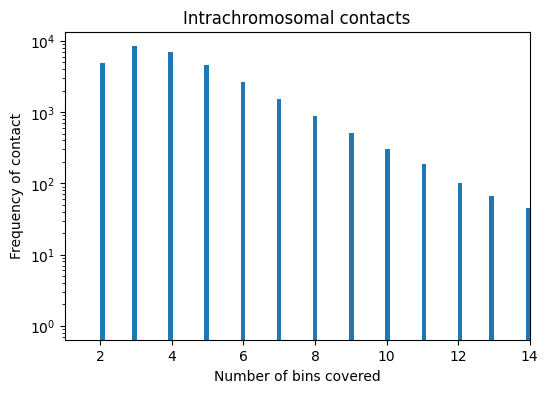

In [140]:
# Generate a histogram
plt.figure(figsize=(6,4))
plt.hist(colsums_reducedDF, bins='auto')

plt.xlim(xmin=1, xmax=14)
plt.yscale('log')

# Add labels and title
plt.xlabel('Number of bins covered')
plt.ylabel('Frequency of contact')
plt.title('Intrachromosomal contacts')

# Display the histogram
plt.show()

In [142]:
ic19_multiedge.is_connected(s=1), ic19_multiedge.is_connected(s=5), ic19_multiedge.is_connected(s=10),ic19_multiedge.is_connected(s=20)

(True, True, False, False)

In [143]:
ic19_multiedge.degree('Bin_1',s = 1), ic19_multiedge.degree('Bin_1',s = 5), ic19_multiedge.degree('Bin_1',s = 8)

(489, 222, 70)

In [303]:
A, names = ic19_multiedge.adjacency_matrix(s = 150, index = True)
A = A.todense()
g = ic19_multiedge.get_linegraph(s = 150, edges = False)
A.shape


(114, 114)

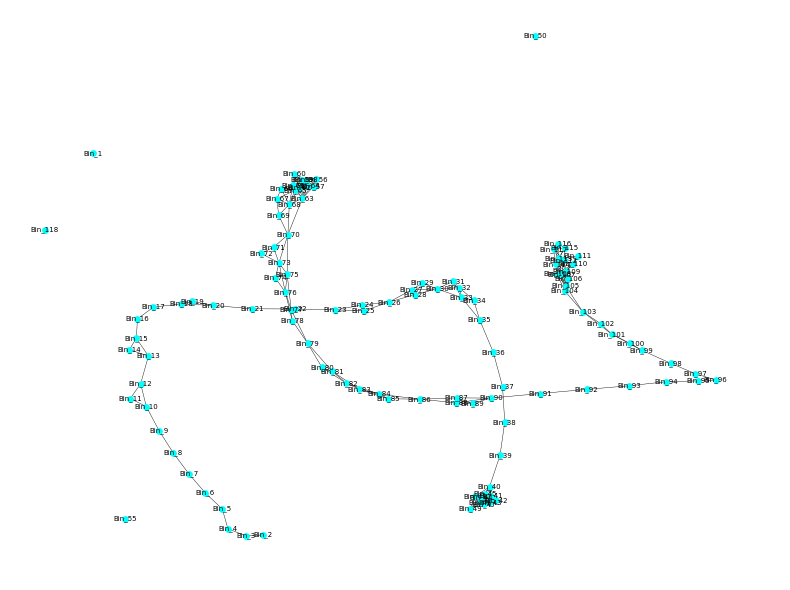

In [304]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(g, with_labels = True, node_size = 15, node_color = "cyan",font_size=5, width = 0.3)
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

In [167]:
graphComps = ic19_multiedge.s_component_subgraphs(s = 300, edges = False,return_singletons=False, name=None)

In [165]:
for index, comp in enumerate(graphComps):
    print(index, comp.number_of_nodes())
    print([n for n in comp.nodes])

0 11
['Bin_106', 'Bin_109', 'Bin_105', 'Bin_108', 'Bin_104', 'Bin_111', 'Bin_103', 'Bin_101', 'Bin_107', 'Bin_110', 'Bin_102']
1 6
['Bin_112', 'Bin_114', 'Bin_117', 'Bin_116', 'Bin_113', 'Bin_115']
2 3
['Bin_19', 'Bin_18', 'Bin_20']
3 3
['Bin_24', 'Bin_26', 'Bin_25']
4 2
['Bin_27', 'Bin_28']
5 2
['Bin_31', 'Bin_32']
6 9
['Bin_44', 'Bin_42', 'Bin_45', 'Bin_47', 'Bin_40', 'Bin_43', 'Bin_41', 'Bin_48', 'Bin_46']


KeyboardInterrupt: 

In [168]:
item_index = 6
smallSG = next(itertools.islice(graphComps, item_index, item_index+1))


In [170]:
smallIncDF = smallSG.incidence_dataframe()
smallSG.number_of_edges(), smallSG.number_of_nodes()

(6993, 9)

In [171]:
colSums_smallSG = smallIncDF.sum()
smallSG_multiEdge = smallIncDF.loc[:, colSums_smallSG >=2]
smallSG_multiEdge_HG = hnx.Hypergraph.from_incidence_dataframe(smallSG_multiEdge)

In [172]:
smallSG_multiEdge_HG.number_of_edges()

3187

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
HD = smallSG_multiEdge_HG.dual()
hnx.draw(smallSG_multiEdge_HG,ax=ax[0])
ax[0].set_title("Subgraph",fontsize=15)
hnx.draw(HD,ax=ax[1])
ax[1].set_title("Subgraph-dual",fontsize=15)

In [183]:
subgraph_fullDF = subsetDF[subsetDF['binID'].isin(["Bin_"+str(x) for x in range(40,48)])]

In [188]:
subgraphIncDF = pd.pivot_table(data=subgraph_fullDF[['ID', 'geneName']], index='geneName', columns='ID', aggfunc=lambda x: 1, fill_value=0)
sg_gene = hnx.Hypergraph.from_incidence_dataframe(subgraphIncDF)
print(sg_gene.number_of_nodes(),sg_gene.number_of_edges())

sg_gene_multiedge = sg_gene.collapse_edges(use_reps = True, return_counts = True)
print(sg_gene_multiedge.number_of_nodes(),sg_gene_multiedge.number_of_edges())

68 11367
68 3496


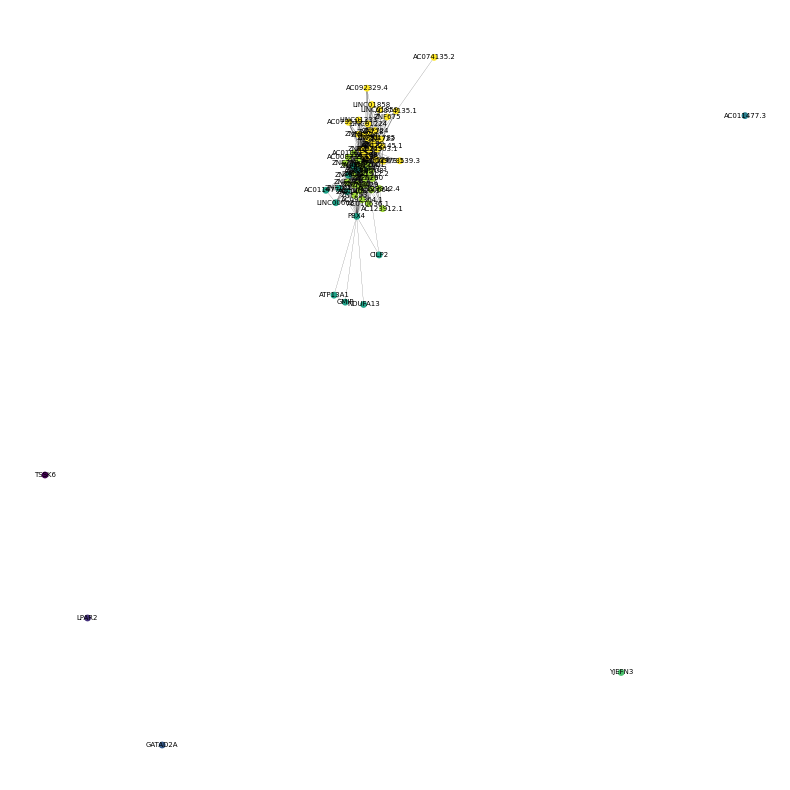

In [298]:
g = sg_gene_multiedge.get_linegraph(s = 10, edges = False)
partition1 = community.best_partition(g)
cmap = cm.get_cmap('viridis_r', max(partition1.values()) + 1)

fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(g)
offset = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Specify the desired offset
nx.draw(g, with_labels = True, node_size = 15, font_size=5, width = 0.1, cmap=cmap, node_color=list(partition1.values()))
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

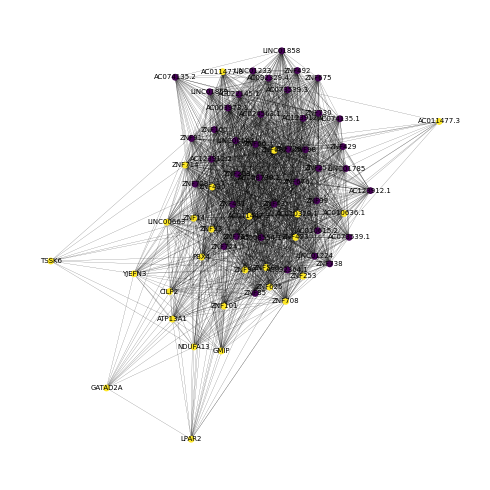

In [202]:
g = sg_gene_multiedge.get_linegraph(s = 2, edges = False)
partition2 = community.best_partition(g)
cmap = cm.get_cmap('viridis', max(partition2.values()) + 1)

fig, ax = plt.subplots(figsize=(5, 5))
pos = nx.spring_layout(g)
offset = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Specify the desired offset
nx.draw(g, with_labels = True, node_size = 15, font_size=5, width = 0.1, cmap=cmap, node_color=list(partition2.values()))
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

In [203]:
## Evaluate clustering efficacy
geneGraph = hmod.precompute_attributes(sg_gene_multiedge)

## generate a random partition into K parts to compare results
K = 5
V = list(sg_gene_multiedge.nodes)
p = np.random.choice(K, size=len(V))
RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
## compute qH
hmod.modularity(geneGraph, RandPart)

-0.006387838012715863

In [204]:
## run Kumar's algorithm, get partition
kumarPart = hmod.kumar(geneGraph)
## Compute qH
print('qH =',hmod.modularity(geneGraph, kumarPart))

qH = 0.16360913303215535


In [227]:
smallSet = sg_gene_multiedge.incidence_dataframe().iloc[:,3:9]
H = hnx.Hypergraph.from_incidence_dataframe(smallSet)

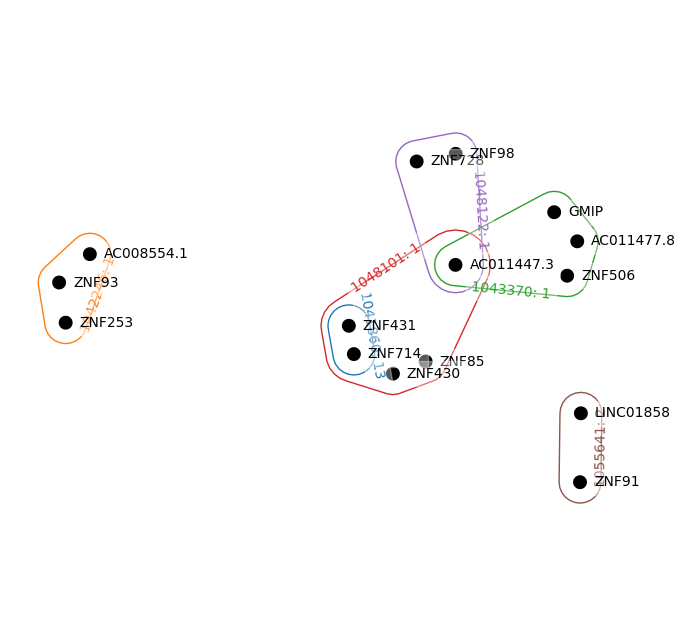

In [228]:
kwargs = {'layout_kwargs': {'seed': 39}, 'with_node_counts': True}

#hnx.drawing.draw(H.collapse_nodes(), **kwargs)
hnx.draw(H)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
HD = sg_gene_multiEdge_HG.dual()
hnx.draw(sg_gene_multiEdge_HG,ax=ax[0])
ax[0].set_title("Gene subgraph",fontsize=15)
hnx.draw(HD,ax=ax[1])
ax[1].set_title("Gene subgraph-dual",fontsize=15)

In [ ]:
HG = HAT.Hypergraph(np.array(sg_gene_multiEdge))
plt.figure(figsize=(5,4))
HG.draw()

## Gene x Read hypergraph with bin edge weights

In [231]:
geneIncDf = pd.pivot_table(data=subsetDF[['ID', 'geneName']], index='geneName', columns='ID', aggfunc=lambda x: 1, fill_value=0)
print(geneIncDf.shape)

colSums_geneIncDf = geneIncDf.sum()
geneDF = geneIncDf.loc[:, colSums_geneIncDf >=2]
geneDF.shape

(1664, 98625)


(1664, 58995)

In [246]:
## Use bin-wise pre-computed weights
geneHG = hnx.Hypergraph.from_incidence_dataframe(geneDF)
for e in geneHG.edges:
    try:
        geneHG.edges[e].weight = weights[e]
    except KeyError:  
        geneHG.edges[e].weight = 1

geneInc_multiedge = geneHG.collapse_edges(use_reps = True, return_counts = True)
print(geneInc_multiedge.number_of_nodes())
print(geneInc_multiedge.number_of_edges())

1664
55582


In [247]:
## Precompute attributes
weighTry = hmod.precompute_attributes(geneInc_multiedge)

In [283]:
## generate a random partition into K parts to compare results
K = 8
V = list(geneInc_multiedge.nodes)
p = np.random.choice(K, size=len(V))
RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
## compute qH
hmod.modularity(weighTry, RandPart)

-0.0004851332658781793

In [249]:
kumarPart = hmod.kumar(weighTry)
## Compute qH
print('qH =',hmod.modularity(weighTry, kumarPart))
print(len(kumarPart))

qH = 0.5277988607717565
8


In [248]:
## build 2-section
G = hmod.two_section(weighTry)
## Louvain algorithm
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ml = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

## Compute qH
print('qH =',hmod.modularity(weighTry, ml))

qH = 0.5279016508198833


In [250]:
len(ml)

8

In [262]:
spliceEffs = pd.read_csv(f'{dataDir}Gene_NucSE',sep="\t", names = ["ID","Gene","SE"])
spliceEffs = spliceEffs.set_index("Gene")

0.950661415326303

In [277]:
def getSE(gene):
    try:
        spEff = spliceEffs.loc[gene,"SE"]
    except KeyError:
        spEff = float('nan')
    return(spEff)

In [308]:
A = [[getSE(gene) for gene in ml[i] if pd.notna(getSE(gene))] for i in range(len(ml))]
B = [[getSE(gene) for gene in RandPart[i] if pd.notna(getSE(gene))] for i in range(len(RandPart))]


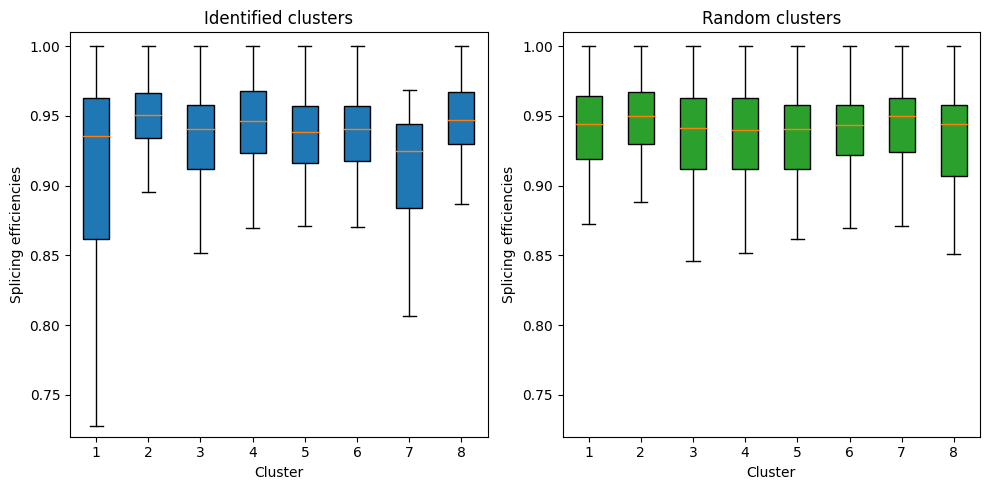

In [316]:
import matplotlib.pyplot as plt


# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a list of x-labels from 1 to the length of the sublists
x_labels = [str(i+1) for i in range(len(A))]


# Plot the boxplot for each sublist
ax1.boxplot(A,showfliers=False,patch_artist = True,
           boxprops = dict(facecolor = "tab:blue"))
ax1.set_ylim([0.72, 1.01])

# Set the x-axis labels and title
ax1.set_xticklabels(x_labels)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Splicing efficiencies')
ax1.set_title('Identified clusters')

# Plot the boxplot for each sublist
ax2.boxplot(B,showfliers=False,patch_artist = True,
           boxprops = dict(facecolor = "tab:green"))
ax2.set_ylim([0.72, 1.01])

# Set the x-axis labels and title
ax2.set_xticklabels(x_labels)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Splicing efficiencies')
ax2.set_title('Random clusters')

# Show the plot
plt.tight_layout()
plt.show()